In [1]:
import tensorflow as tf
import numpy as np
from sklearn.neighbors import NearestNeighbors
import Nearest_Neighbor as nn
import random
from joblib import Parallel, delayed

import importlib
importlib.reload(nn)

cur_user = 'g'

In [2]:
user_profiles = {}
user_profiles['g'] = {}
user_profiles['g']['parallel_jobs'] = 1
user_profiles['g']['data_file_base'] = 'D:/UCSD/F17/CSE293/data_prep_scripts/'
user_profiles['g']['embed_dir'] = 'D:/UCSD/F17/CSE293/'
user_profiles['g']['domain_dir'] = 'D:/UCSD/F17/CSE293/wordtranslation/model/data/'
user_profile = user_profiles[cur_user] 


In [3]:
train_data_file = user_profile['data_file_base'] + "train_data.npy"
train_data = np.load(train_data_file)
test_data_file =  user_profile['data_file_base'] + "test_data.npy"
test_data = np.load(test_data_file)


#train_data_normalized_file = "D:/UCSD/F17/CSE293/data_prep_scripts/train_data_normalized.npy"
#train_data_normalized = np.load(train_data_normalized_file)

#test_data_normalized_file = "D:/UCSD/F17/CSE293/data_prep_scripts/test_data_normalized.npy"
#test_data_normalized = np.load(test_data_normalized_file)

#row-wise normalizing make sure that the data is arranged rowwise
####### ran once to preprocess.

def normalize(X):
    X = (X / np.linalg.norm(X, axis=1)[:,None])
    return X

for lang_data in test_data: #each language
    for item_e in enumerate(lang_data): #for each example
        i, item = item_e
        lang_data[i] = normalize(item) #[[source], [target]]
        
np.save('D:/UCSD/F17/CSE293/data_prep_scripts/test_data_normalized.npy', test_data)

In [6]:
nearest_ne = nn.Nearest_Neighbor(embeddings_dir= user_profile['embed_dir'], domain_dir= user_profile['domain_dir'], lang_list=['es', 'pt', 'en'], k_neighbors=20, flag='test')
             
nearest_ne_train = dict()
'''lang_set = set()
for lang_pairs in train_lang_pairs:
    langs = llang_set = set()
for lang_pairs in train_lang_pairs:
    langs = lang_pairs.split('-')
    lang_set.update(langs)
ang_pairs.split('-')
    lang_set.update(langs)
'''

nearest_ne_train = nn.Nearest_Neighbor(embeddings_dir= user_profile['embed_dir'], domain_dir= user_profile['domain_dir'], lang_list=['pt','es', 'en'], k_neighbors=80, flag='train')


In [11]:
def dist(point, cur_point):
    return np.linalg.norm(point-cur_point)

def farthest_points(row, cur_point):
    dist_list = np.apply_along_axis(dist, 1, row, cur_point)
    indices = np.argsort(dist_list)
    return row[indices[80//2:]]

def match(nn_list, y):
    if y in nn_list:
        return 1
    else:
        return 0

In [12]:
#increase gamma makes model more strict on distance from negative expample i.e. farther from negative, closer to actual
# k is number of negative examples to be passed to calculate loss
class model(object):
    def __init__(self, ckpt_path, lr, dim_lang=5, dim_model=300, k=40, gamma=0.7, model_name="MLPM", lam=0.0001):
        #self.epochs = epochs
        self.ckpt_path = ckpt_path
        self.model_name = model_name
        self.lr = lr
        self.dim_lang = dim_lang
        self.dim_model = dim_model
        self.all_lang_rep_enc = dict()
        self.all_lang_rep_dec = dict()
        self.k = k
        for lang in ["en", "pt", "es"]:
            self.all_lang_rep_enc[lang] = np.random.normal(loc=0.0, scale=1/np.sqrt(float(dim_lang)), size=(dim_lang))
            self.all_lang_rep_dec[lang] = np.random.normal(loc=0.0, scale=1/np.sqrt(float(dim_lang)), size=(dim_lang))
        
        def __graph__():
            tf.reset_default_graph()
            self.graph = tf.Graph()
            with self.graph.as_default():

                # source and target vector representation
                self.source_words = tf.placeholder(tf.float32, shape=[None, dim_model+1])
                self.target_words = tf.placeholder(tf.float32, shape=[None, dim_model])

                self.max_margin_neighbors = tf.placeholder(tf.float32, shape=[None, self.k, dim_model])
                # parameter matrices
                self.encoder = tf.Variable(tf.truncated_normal([dim_model+1, dim_model],\
                                           stddev=1/tf.sqrt(float(dim_model))), name='encoder')

                self.decoder = tf.Variable(tf.truncated_normal([dim_model+1, dim_model],\
                                           stddev=1/tf.sqrt(float(dim_model))), name='decoder')

                #todo:: second dimension can be different that dim_model
                self.lang_encoder = tf.Variable(tf.truncated_normal([dim_lang,dim_model],\
                                               stddev=1/tf.sqrt(float(dim_model))), name='lang_encoder')
                self.lang_decoder = tf.Variable(tf.truncated_normal([dim_lang,dim_model],\
                                               stddev=1/tf.sqrt(float(dim_model))), name='lang_decoder')

                # language representations
                self.lang_rep_enc_placeholder = tf.placeholder(tf.float32, shape=[1,self.dim_lang])
                self.lang_rep_enc = tf.Variable(tf.truncated_normal([1, self.dim_lang],\
                                           stddev=1/tf.sqrt(1.0*dim_lang)))
                self.assign_lang_rep_enc_op = self.lang_rep_enc.assign(self.lang_rep_enc_placeholder)
                
                self.lang_rep_dec_placeholder = tf.placeholder(tf.float32, shape=[1,self.dim_lang])
                self.lang_rep_dec = tf.Variable(tf.truncated_normal([1, self.dim_lang],\
                                           stddev=1/tf.sqrt(1.0*dim_lang)))
                self.assign_lang_rep_dec_op = self.lang_rep_dec.assign(self.lang_rep_dec_placeholder)

                # model equation
                self.target_pred = self.get_model(self.encoder, self.decoder, self.source_words,\
                                                  self.lang_rep_enc, self.lang_rep_dec, self.lang_encoder, self.lang_decoder)

                # cosine distance between target_words and predicted target words
                # A: None*1
                #A = tf.losses.cosine_distance(tf.nn.l2_normalize(self.target_words,dim=1),\
                #                              tf.nn.l2_normalize(self.target_pred,dim=1),\
                #                              dim=1, reduction="none")
                A = tf.norm(self.target_words-self.target_pred, axis=1)
                A = tf.reshape(A, [tf.shape(A)[0] ,1])
                # repeat A k times to use it later for max-margin
                # B: None*k
                B = tf.tile(A, [1, self.k])

                # repeat target_pred k times on row
                # target_pred_k: None*k*dim_model
                
                #todo:: make target pred normalized before repeat
                #target_pred_normalized = tf.nn.l2_normalize(self.target_pred,dim=1)
                target_pred_k = tf.tile(self.target_pred,[1, self.k])
                target_pred_k = tf.reshape(target_pred_k, [tf.shape(self.target_pred)[0], self.k, dim_model])

                #target_pred_k_normalize = tf.nn.l2_normalize(target_pred_k, dim=2)

                #max_margin_neighbors_normalize = tf.nn.l2_normalize(self.max_margin_neighbors, dim=2)


                # cosine distance between target_pred_normalize and k negative targets
                # C: None*k*1 and reshape to None*k
                #C = tf.losses.cosine_distance(target_pred_k_normalize, max_margin_neighbors_normalize, dim=2)
                #C = tf.reshape(C, tf.shape(C)[:2])
                
                C = tf.norm(target_pred_k - self.max_margin_neighbors, axis=2)
                C = tf.reshape(C, tf.shape(C)[:2])

                #max-margin loss
                regularizer = tf.nn.l2_loss(self.encoder)+tf.nn.l2_loss(self.decoder)+\
                              tf.nn.l2_loss(self.lang_encoder)+tf.nn.l2_loss(self.lang_decoder)
                    
                self.loss = tf.reduce_sum(tf.maximum(0.,B-C+gamma)+lam*regularizer)
                #squared loss
                #self.loss = tf.reduce_sum(tf.square(self.target_words-self.target_pred))

                #self.train_step = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)
                self.train_step = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
                self.saver = tf.train.Saver()
                self.init = tf.global_variables_initializer()
        print('start building graph')
        __graph__()
        print('graph built')
        
    # encoder, decoder: 300x300   source_words: Nonex300    lang_rep: 1xdim_lang    lang_coder: dim_langx300
    # Output: Nonex300
    # we calculate the final projection in two parts  
    def get_model(self, encoder, decoder, source_words, lang_rep_enc, lang_rep_dec, lang_encoder, lang_decoder):
        #source to shared using encoder
        shared_source_words = tf.matmul(source_words, encoder)
        shared_lang_rep_enc = tf.matmul(lang_rep_enc, lang_encoder)
        num_examples = tf.shape(shared_source_words)[0]
        #(shared_source_words.get_shape())[0]
        tile = tf.tile(shared_lang_rep_enc, tf.convert_to_tensor([1, num_examples]))
        shared_lang_aux = tf.reshape(tile, [num_examples, self.dim_model])
        shared_embedding_vector = (shared_source_words + shared_lang_aux)
        
        ones = tf.ones([tf.shape(shared_embedding_vector)[0],1], tf.float32)
        shared_embedding_vector = tf.concat([ones, shared_embedding_vector], axis=1)
        #shared to target using decoder
        decoded_word_base = tf.matmul(shared_embedding_vector, decoder)
        shared_lang_rep_dec = tf.matmul(lang_rep_dec, lang_decoder)
        tile = tf.tile(shared_lang_rep_dec, tf.convert_to_tensor([1, num_examples]))
        shared_lang_aux = tf.reshape(tile, [num_examples, self.dim_model])
        
        ret = (decoded_word_base + shared_lang_aux)
        return ret 
    
    def get_feed(self, X, Y, src_lang, dest_lang, Z= None): 
        X = np.insert(X, 0, 1, axis=1)
        feed_dict = {self.source_words: X, self.target_words: Y}
        if (Z is not None):
            feed_dict[self.max_margin_neighbors] = Z
        return feed_dict

#     def get_prediction(self, nearest_ne, lang, pred, target, k_neighbors):
#         def dist(point, cur_point):
#             return np.linalg.norm(point-cur_point)

#         def f(row, cur_point):
#             dist_list = np.apply_along_axis(dist, 1, row, cur_point)
#             indices = np.argsort(dist_list)
#             return row[indices[len(indices)//2:]]
        
#         nearest_neighbors_pred = nearest_ne.knn(pred, lang, k_neighbors)
#         farthest_neighbors_target =[]
#         for cur_point,row in zip(target, nearest_neighbors_pred):
#             farthest_neighbors_target.append(f(row, cur_point))
        
#         return farthest_neighbors_target
        
    #train -> train[en_pt]
    def train(self, train, train_lang_pairs, batch_size, validation, test, test_lang_pairs,nearest_ne, nearest_ne_train ,\
              num_epochs=10, sess=None, log_file="./log_file.txt"):
        saver = self.saver
        if sess == None:
            sess = tf.Session(graph = self.graph)
            sess.run(self.init)              
        with sess.as_default():
            assert sess is tf.get_default_session()
            
            #max data for a language pair/batch size
            max_data_size = int(max([len(x) for x in train])/batch_size)
            batch_counter_outer = 0
            try:
                with open(log_file, 'w') as log :
                    log.write("Batch \t lang_pair \t loss\n")

                    for epoch in range(num_epochs):
                        batch_index = np.zeros(shape=(len(train)), dtype=int)
                        for batch_number in range(max_data_size):
                            #make batches
                            batch_counter_outer += 1

                            for lang_pair_data_enum in enumerate(train):
                                log_string = ""
                                i, lang_pair_data = lang_pair_data_enum
                                lang_pair_data = np.array(lang_pair_data)

                                #rounding on the language pairs with less words in dictionary
                                if batch_index[i] >= len(lang_pair_data):
                                    np.random.shuffle(train[i])
                                    batch_index[i] = 0

                                cur_batch = lang_pair_data[batch_index[i]:(batch_index[i]+batch_size),:,:]
                                batch_index[i] += batch_size

                                X = cur_batch[:,0,:]
                                Y = cur_batch[:,1,:]

                                lang = train_lang_pairs[i].split('-')

                                A = self.all_lang_rep_enc[lang[0]]
                                B = self.all_lang_rep_dec[lang[1]]
                                #init = np.append(A,B)

                                # making shape to (1, 1* dim_lang) from (, 1*dim_lang )
                                A = A.reshape(1, np.shape(A)[0])
                                B = B.reshape(1, np.shape(B)[0])

                                #assign the lang representation for a run
                                sess_lang_rep_enc, sess_lang_rep_dec = sess.run([self.assign_lang_rep_enc_op, self.assign_lang_rep_enc_op] \
                                                              , feed_dict={self.lang_rep_enc_placeholder : A, self.lang_rep_dec_placeholder : B})

                                # get the negative examples wrt the best heuristic (near to prediction and far from target)
                                target_pred = sess.run([self.target_pred], self.get_feed(X, Y, lang[0], lang[1]))
                                Z = self.get_prediction(nearest_ne_train, lang[1], target_pred, Y, 80)

                                # Find k random negative samples for each data word in Y
                                #Z = lang_pair_data[:,1,:][random.sample(range(len(lang_pair_data)),k)]

                                #batch index more that lang pair data length not handled :P
                                _, train_loss, lang_rep_enc, lang_rep_dec, encoder, decoder= \
                                            sess.run([self.train_step, self.loss, self.lang_rep_enc, self.lang_rep_dec, self.encoder, self.decoder],\
                                                     self.get_feed(X, Y, lang[0], lang[1], Z))

                                log_string += str(batch_counter_outer) + " \t " + train_lang_pairs[i] + " \t " + str(train_loss/batch_size) + "\n"
                                log.write(log_string)

                                self.all_lang_rep_enc[lang[0]], self.all_lang_rep_dec[lang[1]] = lang_rep_enc[0], lang_rep_dec[0]

                                #test_code after every iteration
                                if (batch_counter_outer % 10 == 0):
                                    print("Train Loss : " + str(train_loss))
                                    self.test(test, test_lang_pairs, nearest_ne, sess)
                                #
                                #---------------------------------------------------------
                                #print("encoder : ", encoder)
                                #print("decoder : ", decoder)
                                #print("lang_encoder : ", lang_encoder)
                                #print("lang rep : ", lang_rep)
                                #print ("error : ", train_loss)
                                #if (lang[0] == 'pt'):
                                #    print("previous lang rep: ", A)
                                #    print("new lang rep :", lang_rep[0][:self.dim_lang])

                                #print (lang[0], lang_rep[0][:5])
                                #print (lang[1], lang_rep[0][5:])
                                print("Batch:" + str(batch_counter_outer))
                                #-----------------------------------------------------------
                        #save epoch
                        if epoch and epoch%10==0:
                            saver.save(sess, self.ckpt_path+self.model_name+".ckpt", global_step=epoch)

                #print losses #todo: format for train data with lang
                #saver.save(sess, self.ckpt_path+self.model_name+".ckpt", global_step=num_epochs+1)
                    #np.savetxt()
            except KeyboardInterrupt:
                print ('Interupted by keyboard')
                saver.save(sess, self.ckpt_path+self.model_name+".ckpt", global_step=epoch)
                self.session = sess
                return sess

    def get_prediction(self, nearest_ne, lang, pred, target, k_neighbors):        
        #print(np.shape(pred))
        nearest_neighbors_pred = nearest_ne.knn(pred[0], lang, k_neighbors)
        
        farthest_neighbors_target = Parallel(n_jobs= user_profile['parallel_jobs'])(delayed(farthest_points)(row, cur_point) for cur_point,row in zip(target, nearest_neighbors_pred))
                
        return np.array(farthest_neighbors_target)
    
    
    def restore_last_session(self):
        saver = self.saver #tf.train.Saver()
        # create a session
        sess = tf.Session(graph = self.graph) 
        # get checkpoint state
        ckpt = tf.train.get_checkpoint_state(self.ckpt_path)
        # restore session
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        # return to user
        return sess

    def test(self, test, test_lang_pairs, nearest_neighbor, sess, log_file="./test_log_file.txt"):
        for lang_pair_data_enum in enumerate(test):
            i, lang_pair_data = lang_pair_data_enum
            lang_pair_data = np.array(lang_pair_data)
            
            lang = test_lang_pairs[i].split('-')
            A = self.all_lang_rep_enc[lang[0]]
            B = self.all_lang_rep_dec[lang[1]]
            
                        
            # making shape to (1, 1* dim_lang) from (, 1*dim_lang )
            A = A.reshape(1, np.shape(A)[0])
            B = B.reshape(1, np.shape(B)[0])

            #assign the lang representation for a run
            #sess_lang_rep = sess.run(self.assign_lang_rep_op, feed_dict={self.lang_rep_placeholder : init})
            sess_lang_rep_enc, sess_lang_rep_dec = sess.run([self.assign_lang_rep_enc_op, self.assign_lang_rep_enc_op] \
                                                          , feed_dict={self.lang_rep_enc_placeholder : A, self.lang_rep_dec_placeholder : B})

            
            X = lang_pair_data[:,0,:]
            Y = lang_pair_data[:,1,:]
            
            # Find k random negative samples for each data word in Y
            #todo: change this to nearest neighbor hueristic
            target_pred = sess.run([self.target_pred], self.get_feed(X, Y, lang[0], lang[1]))
            Z = self.get_prediction(nearest_ne_train, lang[1], target_pred, Y, 80)
            
            #print (np.shape(Z))
            #print (Z)
            #batch index more that lang pair data length not handled :P
            test_loss, target_pred = sess.run([self.loss, self.target_pred], self.get_feed(X, Y, lang[0], lang[1], Z))
            near_points = nearest_neighbor.knn(target_pred, lang[1], 20)
            self.calculate_precision(near_points, Y)
            print('--------------------')
            print(lang)
            print("Test loss: ", test_loss)
            
            '''print('P@1: ', nn(1))
            print('P@5: ', nn(5))
            print('P@10: ', nn(10))'''
            break
     
    def calculate_precision(self, predictions_nn, actual):
        pos = 0
        total = len(actual)
        #print("actual:", actual[0])
        #print("pred:", predictions_nn[0][0])            
        pos = np.sum(Parallel(n_jobs=user_profile['parallel_jobs'])(delayed(match)(nn_list, y) for nn_list, y in zip(predictions_nn, actual)))
        '''
        for (i, y) in enumerate(actual):
            if y in predictions_nn[i]:
                pos+=1
        '''
        print(str(pos) + "out of " + str(total))

In [13]:
mlpm = model(ckpt_path="./ckpt/",lr=0.001, lam=0.00000, dim_lang=5)

start building graph
graph built


In [14]:
train_data_ = train_data
test_data_ = [train_data[0]]
#sess = mlpm.restore_last_session()
sess = None

In [15]:
# mlpm.train(train_data_normalized,train_lang_pairs= ["pt-es", "pt-en", "en-es"], batch_size=40, validation=[], test= test_data_normalized, test_lang_pairs=["pt-es"])
mlpm.train(train_data_,train_lang_pairs= ["pt-es", "pt-en", "en-es"], num_epochs=100, batch_size=70, validation=[], test= test_data_, test_lang_pairs=["pt-es"], nearest_ne=nearest_ne, nearest_ne_train=nearest_ne_train, sess = sess)

Batch:1
Batch:1
Batch:1
Batch:2
Batch:2
Batch:2
Batch:3
Batch:3
Batch:3
Batch:4
Batch:4
Batch:4
Batch:5
Batch:5
Batch:5
Batch:6
Batch:6
Batch:6
Batch:7
Batch:7
Batch:7
Batch:8
Batch:8
Batch:8
Batch:9
Batch:9
Batch:9
Train Loss : 696.32
28out of 303
--------------------
['pt', 'es']
Test loss:  8188.58
Batch:10
Train Loss : 2866.19
28out of 303
--------------------
['pt', 'es']
Test loss:  8111.65
Batch:10
Train Loss : 3743.19
26out of 303
--------------------
['pt', 'es']
Test loss:  8044.74
Batch:10
Batch:11
Batch:11
Batch:11
Batch:12
Batch:12
Batch:12
Batch:13
Batch:13
Batch:13
Batch:14
Batch:14
Batch:14
Batch:15
Batch:15
Batch:15
Batch:16
Batch:16
Batch:16
Batch:17
Batch:17
Batch:17
Batch:18
Batch:18
Batch:18
Batch:19
Batch:19
Batch:19
Train Loss : 382.98
41out of 303
--------------------
['pt', 'es']
Test loss:  6336.26
Batch:20
Train Loss : 2271.52
42out of 303
--------------------
['pt', 'es']
Test loss:  6310.48
Batch:20
Train Loss : 3092.83
42out of 303
--------------------
['p

Batch:153
Batch:153
Batch:154
Batch:154
Batch:154
Batch:155
Batch:155
Batch:155
Batch:156
Batch:156
Batch:156
Batch:157
Batch:157
Batch:157
Batch:158
Batch:158
Batch:158
Batch:159
Batch:159
Batch:159
Train Loss : 18.3103
88out of 303
--------------------
['pt', 'es']
Test loss:  182.61
Batch:160
Train Loss : 32.795
88out of 303
--------------------
['pt', 'es']
Test loss:  184.246
Batch:160
Train Loss : 2000.1
88out of 303
--------------------
['pt', 'es']
Test loss:  186.038
Batch:160
Batch:161
Batch:161
Batch:161
Batch:162
Batch:162
Batch:162
Batch:163
Batch:163
Batch:163
Batch:164
Batch:164
Batch:164
Batch:165
Batch:165
Batch:165
Batch:166
Batch:166
Batch:166
Batch:167
Batch:167
Batch:167
Batch:168
Batch:168
Batch:168
Batch:169
Batch:169
Batch:169
Train Loss : 11.8333
89out of 303
--------------------
['pt', 'es']
Test loss:  147.615
Batch:170
Train Loss : 26.1594
89out of 303
--------------------
['pt', 'es']
Test loss:  149.237
Batch:170
Train Loss : 2133.02
89out of 303
---------

In [44]:
sess =  mlpm.restore_last_session()

INFO:tensorflow:Restoring parameters from ./ckpt/MLPM.ckpt-34


In [5]:
[len(train_data[i]) for i in range(3)]

[303, 415, 151632]

In [34]:

test_error = []
with open("result_final") as f:
    for l in f:
        if "Test loss" in l:
            #print (l.split())
            test_error.append((float)(l.split()[2]))

In [35]:
test_error

[8188.58,
 8111.65,
 8044.74,
 6336.26,
 6310.48,
 6286.28,
 5249.62,
 5224.02,
 5203.35,
 4032.93,
 4008.8,
 3987.7,
 2946.84,
 2933.7,
 2926.82,
 2098.56,
 2085.53,
 2077.09,
 1434.3,
 1434.17,
 1436.54,
 975.199,
 974.774,
 979.663,
 690.148,
 696.474,
 706.964,
 467.614,
 469.019,
 472.787,
 350.245,
 355.191,
 362.1,
 283.375,
 287.007,
 292.587,
 221.27,
 221.444,
 223.254,
 186.232,
 189.469,
 193.415,
 173.575,
 176.973,
 181.945,
 182.61,
 184.246,
 186.038,
 147.615,
 149.237,
 151.295,
 134.894,
 135.088,
 136.293,
 134.142,
 135.207,
 137.076,
 128.685,
 128.445,
 129.764,
 123.496,
 125.085,
 127.042,
 138.92,
 145.051,
 152.339]

In [33]:
import matplotlib.pyplot as plt

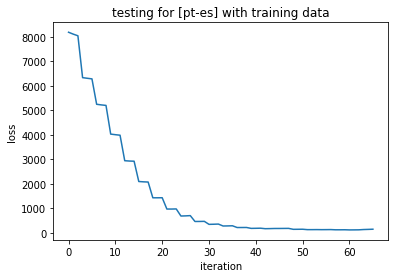

In [39]:
plt.plot(test_error)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('testing for [pt-es] with training data')
plt.show()